<a href="https://colab.research.google.com/github/Systemita12/TesisPrototipo/blob/main/Aquitectura1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Image classification from scratch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard



In [ ]:
# Ruta a la carpeta raíz de tu dataset en Google Drive
data_dir = '/content/drive/My Drive/DataTest'

image_size = (224, 224)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 6910 files belonging to 2 classes.
Using 5528 files for training.
Using 1382 files for validation.


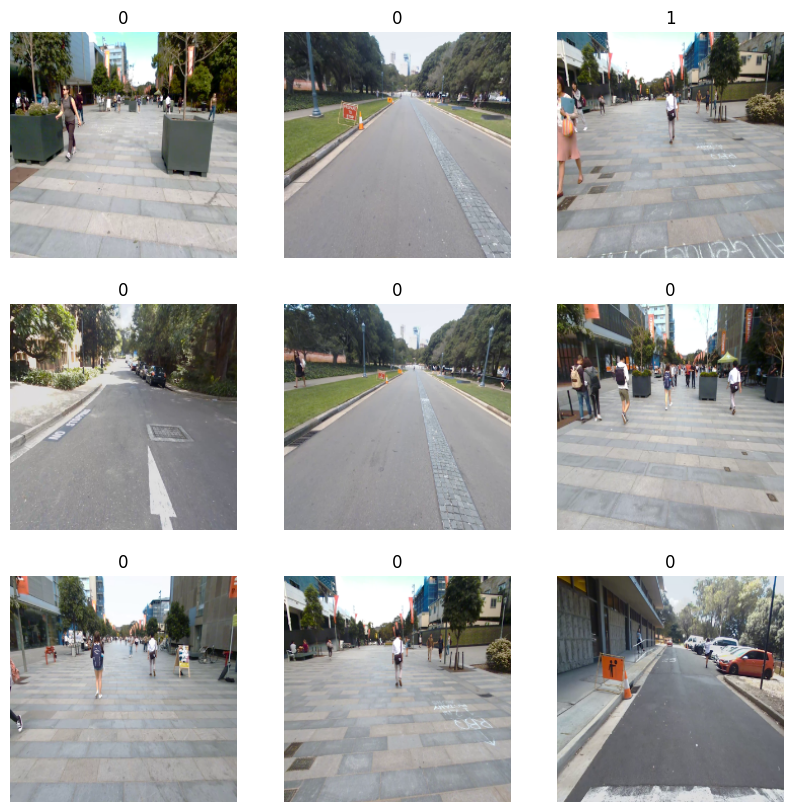

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

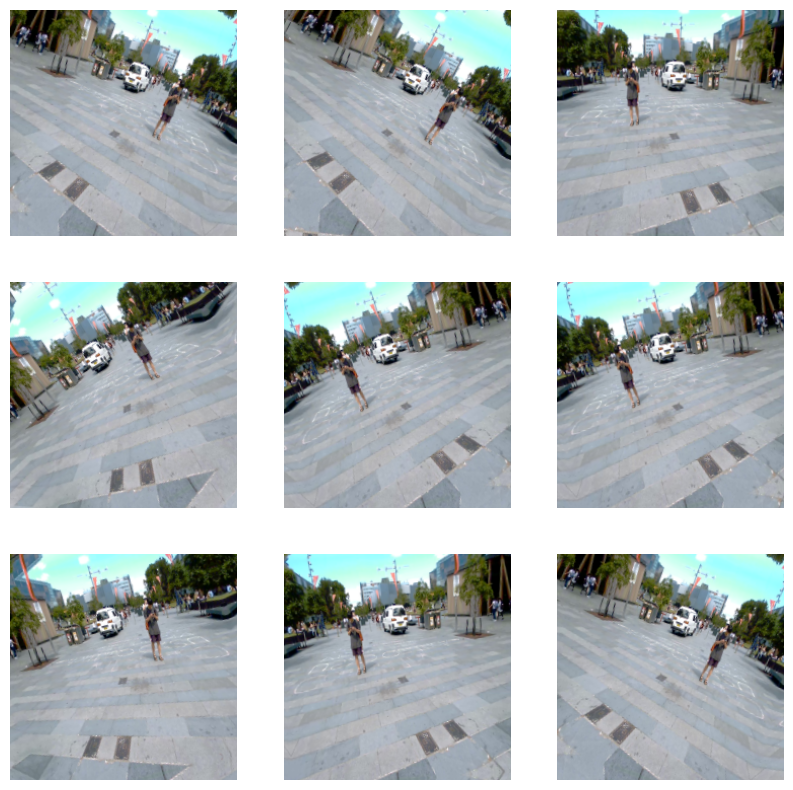

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

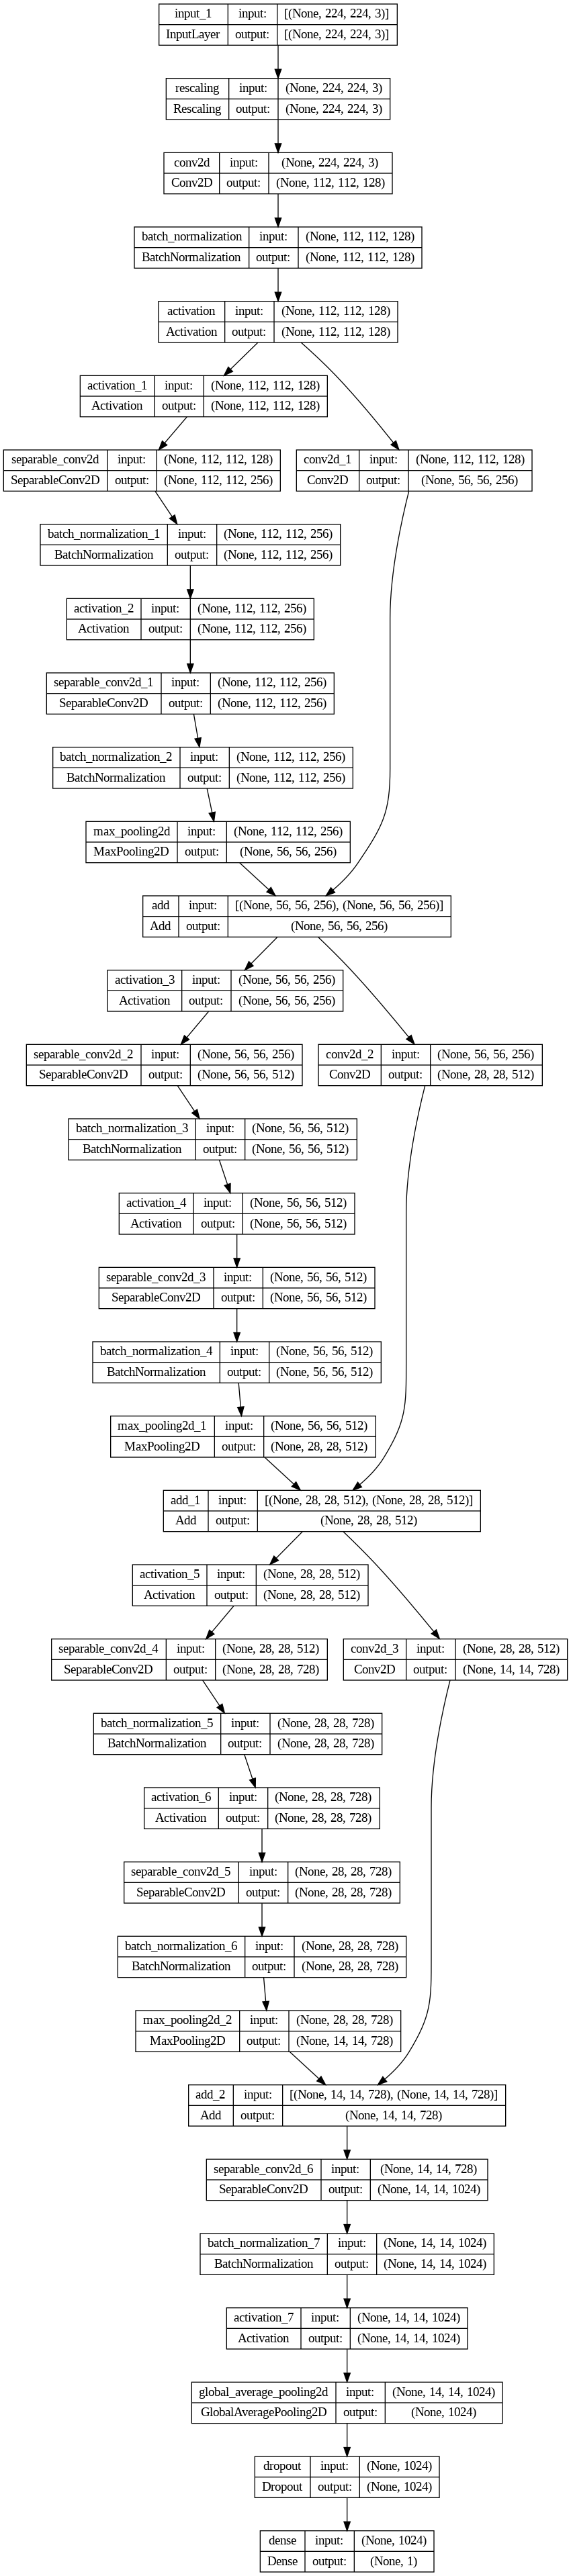

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
log_dir = "/content/drive/My Drive/TensorBoard/Arquitectura1"  # Ruta donde se guardarán los registros de TensorBoard en Google Drive
tensorboard_callback = TensorBoard(log_dir=log_dir)

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    tensorboard_callback
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
44/44 [==============================] - 1239s 28s/step - loss: 0.5331 - accuracy: 0.7876 - val_loss: 0.6648 - val_accuracy: 0.7923
Epoch 2/25
44/44 [==============================] - 1277s 29s/step - loss: 0.5196 - accuracy: 0.7983 - val_loss: 0.6266 - val_accuracy: 0.7923
Epoch 3/25
44/44 [==============================] - 1179s 27s/step - loss: 0.5204 - accuracy: 0.7988 - val_loss: 0.5870 - val_accuracy: 0.7923
Epoch 4/25
44/44 [==============================] - 1128s 26s/step - loss: 0.5161 - accuracy: 0.7990 - val_loss: 0.5990 - val_accuracy: 0.7923
Epoch 5/25
44/44 [==============================] - 1239s 28s/step - loss: 0.5179 - accuracy: 0.7979 - val_loss: 0.5369 - val_accuracy: 0.7923
Epoch 6/25
44/44 [==============================] - 1170s 27s/step - loss: 0.5142 - accuracy: 0.8014 - val_loss: 0.5415 - val_accuracy: 0.7923
Epoch 7/25
44/44 [==============================] - 1203s 27s/step - loss: 0.5151 - accuracy: 0.7985 - val_loss: 0.5594 - val_accuracy: 0.7923

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image

# Cargar una imagen de prueba
image_path = "/content/drive/My Drive/Teste/Ruta3.jpg"  # Ruta a la imagen que deseas predecir
img = image.load_img(image_path, target_size=(180, 180))  # Asegúrate de que coincida con el tamaño de entrada de tu modelo
img = image.img_to_array(img)
img = tf.expand_dims(img, 0)  # Añadir una dimensión para el lote (batch)

# Realizar la predicción
predictions = model.predict(img)
predicted_class = tf.argmax(predictions[0]).numpy()

# Obtener el nombre de la clase predicha
class_names = ["clase1", "clase2"]  # Reemplaza con los nombres de tus clases
predicted_class_name = class_names[predicted_class]

print(f"La imagen es de la clase: {predicted_class_name}")